# AskScience Subreddits 

Author: Ramin Anushiravani

Date: August 6th/2023 

Following [subreddit](../data/askscience_data.csv) contains posts and questions on science on Reddit. We're asked to determine the score (number of upvotes?) a post would get on this subreddit using the title and body of the post and possibly other included metadata. 

We're only looking at the post, not the comments. This is a key information to understanding why a post is successful and engaging on a reddit. Although, during inference we don't have access to comments, it can help us understand what about the post was more intriguing.

I included a notebook [here](../notebook/extracting_comments_from_posts.py) that extract comments from the reddit post using the included URL. I did not use comments when doing the modelling though. 

In [52]:
import pandas as pd
from collections import Counter
from pandas_profiling import ProfileReport
import sys
import seaborn as sns
from matplotlib.pylab import plt
import copy
import numpy as np
pd.options.mode.chained_assignment = None
from IPython.display import Image, display
from sklearn.model_selection import train_test_split

sys.path.insert(1, '../')
from utils.data_utility import DataUtil

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [53]:
path_to_data = '../data/'
dutil = DataUtil()
df_science = pd.read_csv(path_to_data + 'askscience_data.csv').drop('Unnamed: 0',axis=1)
df_science.describe()

,score,upvote_ratio
count,4205.000000,4205.000000
mean,3730.471106,0.765719
std,5577.606541,0.177537
min,0.000000,0.170000
25%,4.000000,0.590000
50%,35.000000,0.840000
75%,7472.000000,0.920000
max,83382.000000,1.000000


## Is it a question? 
Is the title a question? Are there questions in the response body? After all this is a thread for asking science questions. 

## Author Name
Features such as the author name though may be important if the author is "famous", would not give a clear indication of whether a new author's post will get more upvote scores. It might also be a case where an author name include their topic of interest which could show their passion about a specific post.

However, such feature are unlikly to be robust and for this excerise I'm going to ignore them with one exception. It seems like a a good chunk of authors are marked as "deleted and some as "AskScienceModerator" I'm not sure what deleted is referring too, but it might be worthwhile to keep track of "deleted"/"AskScienceModerator"/neither. 

## Date
Dates might be important. For example, it might be holiday. Though, since reddits is available to everyone aroudn the world, I don't think the time would indicate much without knowing the user's time-zone. 

## Title/Body Size
How long a title or body is might be important, more detail maybe better, though there might be a cut off. 

## Number of links mentioned in the post
A post that cites more links might be imporatant as it could show how trust-worthy the post is. 

## Tag
Some topics might be "hot" at certain times and cause more people to interact with them. 

## Content 
The contents included in the title and body (specially the title) are perhaps the most important signal. 

## Edit
In some cases the author seems to have edited the post specially when more users are commenting on it

## bold
Is there a lot of bold in the body? That might grab some user's attention 

## nice
Is the user being nice, thankful? 

In [54]:
df_science = df_science.fillna('')
df_science['num_questions_title'] = df_science['title'].apply(lambda x : dutil.count_qs(x))
df_science['num_questions_body'] = df_science['body'].apply(lambda x : dutil.count_qs(x))
df_science['num_cite'] = df_science['body'].apply(lambda x : dutil.count_links_cited(x))

Putting authors into 3 categories

In [55]:
df_science['author_kind_1'] = np.where(df_science['author'] == 'DELETED', 1, 0)
df_science['author_kind_2'] = np.where(df_science['author'] == 'AskScienceModerator', 2, 0)
df_science['author_kind']   = df_science['author_kind_1'] + df_science['author_kind_2']
x = df_science.pop('author_kind_1')
x = df_science.pop('author_kind_2')

In [56]:
# it's missing one of the links that doesn't include www/http but that's probably okay
index = 14
check_url = df_science[df_science['num_cite']>1]
print(check_url['body'].iloc[index], '\n\n-----'+ "Num Cites: " + str(check_url['num_cite'].iloc[index]))

Question in title. 

Just curious if other species have rebounded that we are aware of. 

Thank you in advance. 

Edit: Really interesting answers by everyone so far. Thank you! 

Edit 2: Follow up question. What are the biological implications when a species that we thought was extinct, rebounds it's population? Is it just limited to things like focusing on changing what caused their extinction in the first place, like eradicating the rats in the "tree lobster" article? 

Edit 3: Holy cow ladies and gents. I never thought I would get this much feedback on my post. It's going to take me a bit to read through it. But I will. In the mean time, thank you again, from the bottom of my heart, for all your answers and feedback. 

Edit 4: Here are a couple links that led me to believe that the sightings had increased and were credible enough to be taken seriously by scientists.  (copy/pasted from a buried comment) 
 Here is a different [news source](https://www.yahoo.com/amphtml/tech/extinct-c

# Feature Extraction

To capture more interesting reddits, including only those that are getting up/down votes


In [57]:
df_science['tag'] = df_science['tag'].apply(lambda x: ' '.join(x.lower().split()))

Some tags are clearly correlated to getting more up-votes, e.g, anthropology however the dataset is not normally distributed across different tags. There are over 500 physics tag and only 2 liguistic tag. There are also several posts without a tag. 

In [59]:
tag_count = Counter(df_science['tag'])
tag_index = {i:t for t,i in enumerate(tag_count.keys())}

df_science['year']      = pd.DatetimeIndex(df_science['datetime']).year
df_science['month']     = pd.DatetimeIndex(df_science['datetime']).month
df_science['day']       = pd.DatetimeIndex(df_science['datetime']).day
df_science['title_len'] = df_science['title'].apply(lambda x:len(x))
df_science['body_len']  = df_science['body'].apply(lambda x:len(x))
df_science['tag_index'] = df_science['tag'].apply(lambda x:tag_index[x])
df_science['edit']      = df_science['body'].apply(lambda x:int('edit' in x.lower())*Counter(x.lower().split())['edit'])
df_science['bold_B']    = df_science['body'].apply(lambda x:int('**' in x.lower())*Counter(x.lower().split())['**'])
df_science['nice']      = df_science['body'].apply(lambda x:int('thank' in x.lower())*Counter(x.lower().split())['thank'])
df_science['nice']     += df_science['body'].apply(lambda x:int('thanks' in x.lower())*Counter(x.lower().split())['thanks'])
df_science['nice']     += df_science['body'].apply(lambda x:int(':)' in x.lower())*Counter(x.lower().split())[':)'])
df_science.to_csv(path_to_data + 'askscience_feat.csv')

# Understanding Scores

Scores and up-vote ratio don't look like a normal distribtion (maybe two normal?). This might make this problem difficult to solve with traditional linear regression models. Perhaps we could instead solve this prediction problem as a classification problem on a pre-determined number of bins on upVote ratio. 


In [8]:
df_science_votes = copy.copy(df_science)

df_train          = copy.copy(df_science_votes)

df_train.pop('title')
df_train.pop('body')
df_train.pop('datetime')
df_train.pop('author')
df_train.pop('url')
df_train.groupby('tag').agg(['median'])


,score,upvote_ratio,num_questions_title,num_questions_body,num_cite,author_kind,year,month,day,title_len,body_len,tag_index,edit,bold_B,nice
,median,median,median,median,median,median,median,median,median,median,median,median,median,median,median
tag,,,,,,,,,,,,,,,
,1.0,0.525,1.0,1.0,0.0,0.0,2011.0,7.0,15.5,70.5,196.0,11.0,0.0,0.0,0.0
anthropology,6275.0,0.910,1.0,1.0,0.0,0.0,2018.0,8.0,17.0,88.0,177.0,16.0,0.0,0.0,0.0
archaeology,22.0,0.800,1.0,1.0,0.0,0.0,2022.0,10.0,17.0,107.0,305.0,24.0,0.0,0.0,0.0
astronomy,64.5,0.880,1.0,1.0,0.0,0.0,2019.0,6.0,15.0,90.0,77.0,9.0,0.0,0.0,0.0
biology,95.0,0.880,1.0,1.0,0.0,0.0,2022.0,7.0,15.0,83.5,62.0,4.0,0.0,0.0,0.0
cern ama,6776.0,0.880,1.0,2.0,17.0,0.0,2016.0,5.0,26.0,174.0,3991.0,23.0,0.0,0.0,2.0
chemistry,10.0,0.770,1.0,1.0,0.0,0.0,2022.0,5.0,13.0,72.0,108.0,15.0,0.0,0.0,0.0
computing,6521.5,0.870,1.0,1.0,0.0,0.0,2018.0,7.0,11.5,93.0,62.5,17.0,0.0,0.0,0.0


Text(0.5, 1.0, 'UpVote Ratio Distribution')

<Figure size 360x360 with 0 Axes>

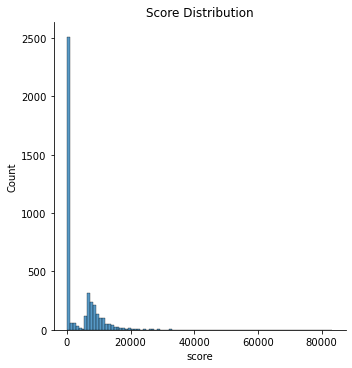

<Figure size 360x360 with 0 Axes>

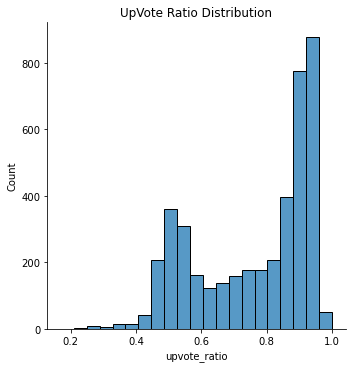

In [9]:
plt.figure(figsize=(5,5))
sns.displot(df_train.score)
plt.title('Score Distribution')
plt.figure(figsize=(5,5))
sns.displot(df_train.upvote_ratio) 
plt.title('UpVote Ratio Distribution')

In [10]:
# These post did not get any scores
df_zero_score = df_train[df_train['score'] == 0]
df_zero_score[df_zero_score['upvote_ratio']!=0.5]

,tag,score,upvote_ratio,num_questions_title,num_questions_body,num_cite,author_kind,year,month,day,title_len,body_len,tag_index,edit,bold_B,nice
1023,human body,0.0,0.48,2,0,0,0,2022,12,8,211,0,0,0,0,0
1029,human body,0.0,0.47,1,1,0,0,2022,12,7,62,594,0,0,0,0
1080,medicine,0.0,0.45,1,1,1,0,2022,12,3,31,409,3,0,0,0
1182,biology,0.0,0.33,1,0,0,0,2022,11,23,71,0,4,0,0,0
1196,chemistry,0.0,0.40,1,0,0,0,2022,11,23,34,0,15,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4117,earth sciences,0.0,0.44,1,5,2,0,2022,1,18,35,630,8,0,0,0
4118,physics,0.0,0.31,1,0,0,0,2022,1,18,75,0,2,0,0,0
4126,covid-19,0.0,0.30,1,1,1,0,2022,1,17,61,335,7,0,0,0
4183,covid-19,0.0,0.40,3,0,0,0,2022,1,14,122,0,7,0,0,0


let's take a look at one of them. This thread has also some activity and scores associate with it. 

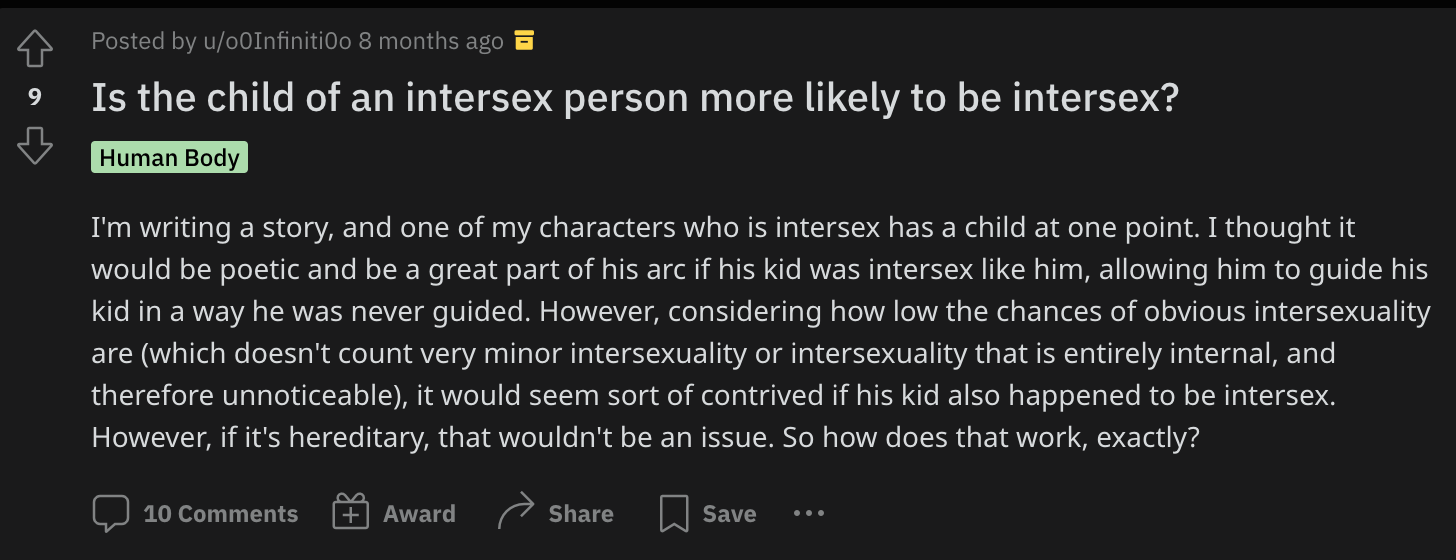

In [11]:
df_science.iloc[1029]['url']
display(Image(filename='../snapshots/red_no_score.png'))

A closer look at the ones that have no scores and lower up-vote ratio seems to be due to the post being deleted by the original person who posted it. 

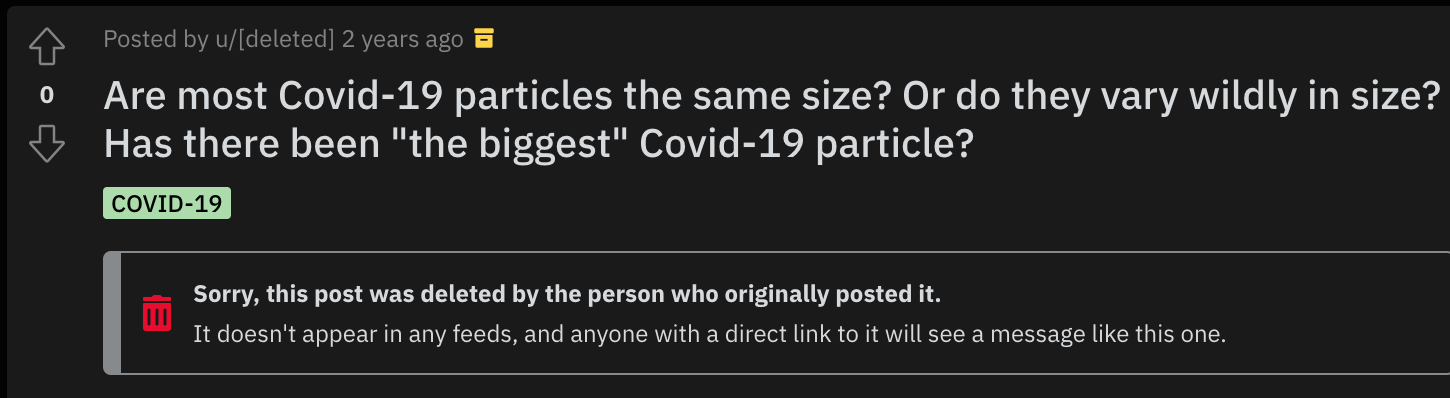

In [12]:
df_science.iloc[4183]['url']
display(Image(filename='../snapshots/red_no_score_low_up.png'))

In [13]:
# These post did not get any scores or votes
df_zero_score_upvote = df_zero_score[df_zero_score['upvote_ratio'] == 0.5]
df_zero_score_upvote

,tag,score,upvote_ratio,num_questions_title,num_questions_body,num_cite,author_kind,year,month,day,title_len,body_len,tag_index,edit,bold_B,nice
6,biology,0.0,0.5,1,2,0,0,2022,12,9,32,232,4,0,0,0
1025,chemistry,0.0,0.5,1,1,0,0,2022,12,8,124,303,15,0,0,0
1079,medicine,0.0,0.5,1,3,0,0,2022,12,3,66,324,3,0,0,0
1143,human body,0.0,0.5,1,2,0,0,2022,11,28,62,529,0,0,0,0
1150,earth sciences,0.0,0.5,1,4,0,0,2022,11,29,41,985,8,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3808,biology,0.0,0.5,1,2,0,0,2022,2,4,60,466,4,0,0,0
3812,biology,0.0,0.5,1,5,0,0,2022,2,4,65,365,4,0,0,0
3978,engineering,0.0,0.5,1,2,0,0,2022,1,25,33,185,13,0,0,0
4004,biology,0.0,0.5,2,1,0,0,2022,1,24,87,66,4,0,0,0


Let's take a look at one of these results. 
In fact this post has some comments and up-votes as well. So, it might be that at the time of creation these were not extracted or that there were other data quality issues when extracting them. 

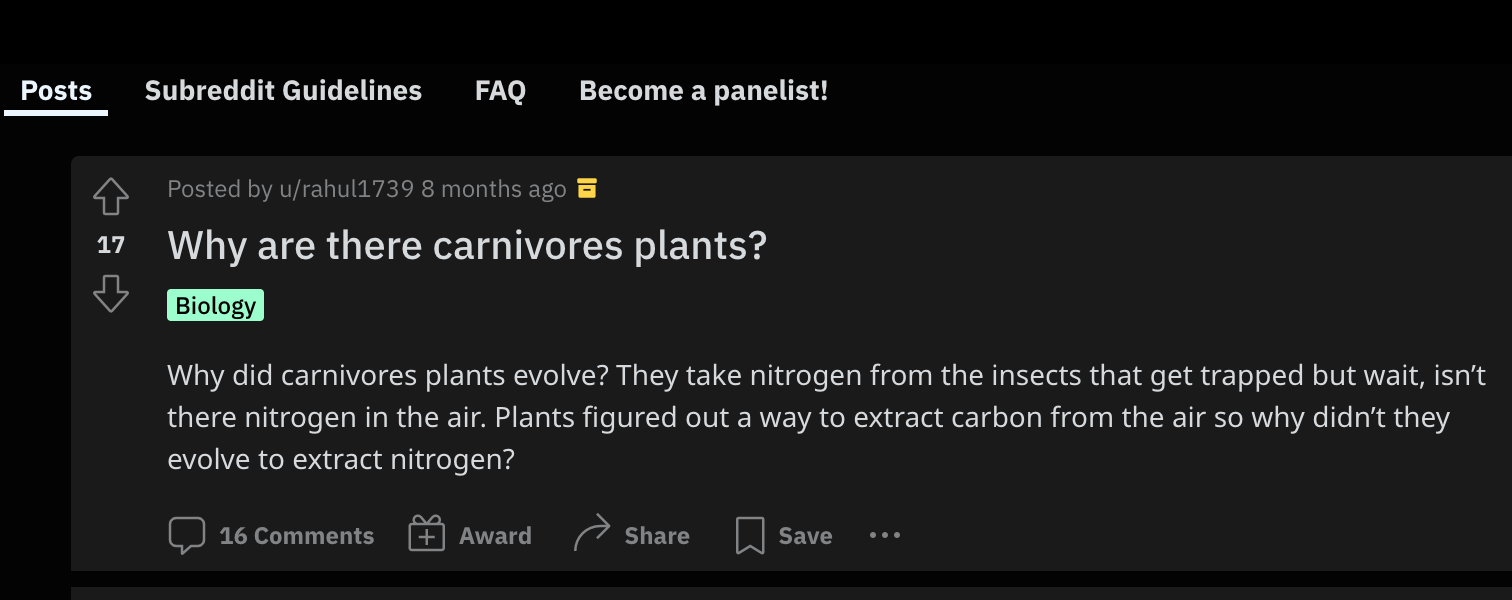

In [14]:
df_science.iloc[6]['url']
from IPython.display import Image, display
display(Image(filename='../snapshots/red_no.png'))

Putting upvote ratio to bins using 15 units. 
I also tried quantiling the raw scores into bins, to create a balanced classes. 
Later, we could look into converting the up-vote bins to the raw scores.  

Let's remove any of the samples that did not get any scores as they may be suffering from data quality or issues. 

In [15]:
df_train_selected = df_train[df_train['score'] !=0 ]

Text(0.5, 1.0, 'score_bins Distribution')

<Figure size 360x360 with 0 Axes>

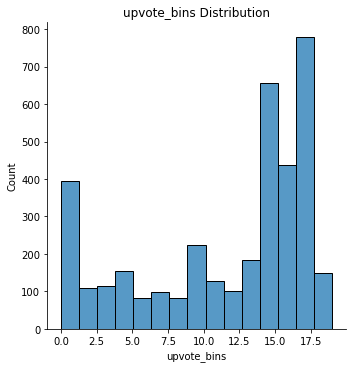

<Figure size 360x360 with 0 Axes>

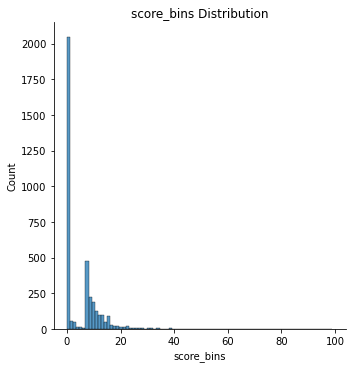

In [16]:
df_train_selected['upvote_bins'] = pd.cut(df_train_selected.upvote_ratio, 20, labels=False) 
df_train_selected['score_bins'] = pd.cut(df_train_selected.score,100, labels=False)

plt.figure(figsize=(5,5))
sns.displot(df_train_selected.upvote_bins)
plt.title('upvote_bins Distribution')
plt.figure(figsize=(5,5))
sns.displot(df_train_selected.score_bins)
plt.title('score_bins Distribution')

Note that the score bins are still very bottom heavy. This is a problem as the model will learn to understimate the score. To counter this can oversample the rows of the model.  

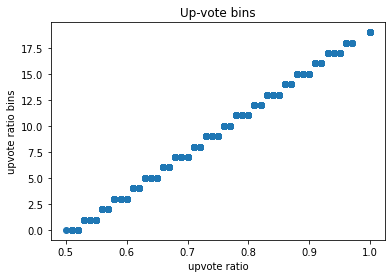

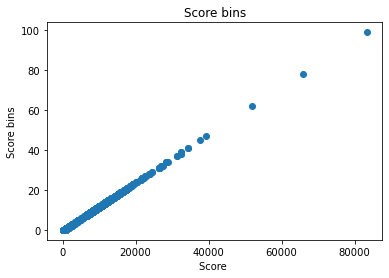

In [17]:
plt.scatter(df_train_selected.upvote_ratio,df_train_selected.upvote_bins)
plt.title('Up-vote bins')
plt.xlabel('upvote ratio')
plt.ylabel('upvote ratio bins')
plt.show()

plt.scatter(df_train_selected.score,df_train_selected.score_bins)
plt.title('Score bins')
plt.xlabel('Score ')
plt.ylabel('Score bins')

plt.show()

Length of title and bodies are normally distribted. Most reddits are from 2022. 
Majority of reddits don't have any votes. 

Further looking at the correlation, we can infer some information. 

For example, number of questions in the body is negatively correlatedwith the score, while a longer title seem to be positively correlated. 

<AxesSubplot:>

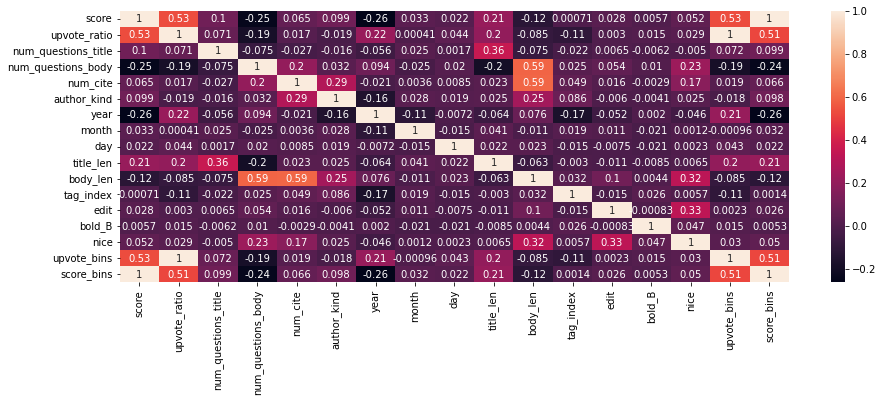

In [18]:
plt.figure(figsize=(15,5))
sns.heatmap(df_train_selected.corr(),annot=True)

In [19]:
df_train_selected.groupby('upvote_bins').agg(['median'])
df_train_selected.groupby('score_bins').agg(['median'])

/var/folders/yr/_5d8vnxd6z58c56nmqh8nykw0000gn/T/ipykernel_70087/159275379.py:1: FutureWarning: ['tag'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  df_train_selected.groupby('upvote_bins').agg(['median'])
/var/folders/yr/_5d8vnxd6z58c56nmqh8nykw0000gn/T/ipykernel_70087/159275379.py:2: FutureWarning: ['tag'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  df_train_selected.groupby('score_bins').agg(['median'])


,score,upvote_ratio,num_questions_title,num_questions_body,num_cite,author_kind,year,month,day,title_len,body_len,tag_index,edit,bold_B,nice,upvote_bins
,median,median,median,median,median,median,median,median,median,median,median,median,median,median,median,median
score_bins,,,,,,,,,,,,,,,,
0,9.0,0.720,1.0,1.0,0.0,0.0,2022.0,4.0,15.0,74.0,197.0,4.0,0.0,0.0,0.0,8.0
1,1162.0,0.910,1.0,2.0,0.0,0.0,2022.0,10.0,14.0,78.0,287.5,3.0,0.0,0.0,0.0,16.0
2,1963.0,0.930,1.0,1.0,0.0,0.0,2022.0,10.0,18.0,91.0,226.0,4.0,0.0,0.0,0.0,17.0
3,2909.0,0.940,1.0,1.0,0.0,0.0,2022.0,8.0,15.0,107.0,182.0,4.0,0.0,0.0,0.0,17.0
4,3825.5,0.935,1.0,1.0,0.0,0.0,2022.0,2.5,20.0,89.0,271.5,6.0,0.0,0.0,0.0,17.0
5,4463.5,0.940,1.0,1.0,0.0,0.0,2022.0,2.5,9.5,92.5,227.0,6.0,0.0,0.0,0.0,17.0
6,5561.0,0.940,1.0,1.0,0.0,0.0,2022.0,6.0,9.0,80.5,146.5,5.0,0.0,0.0,0.0,17.0
7,6407.0,0.930,1.0,0.0,0.0,0.0,2019.0,7.0,13.0,99.0,0.0,5.0,0.0,0.0,0.0,17.0


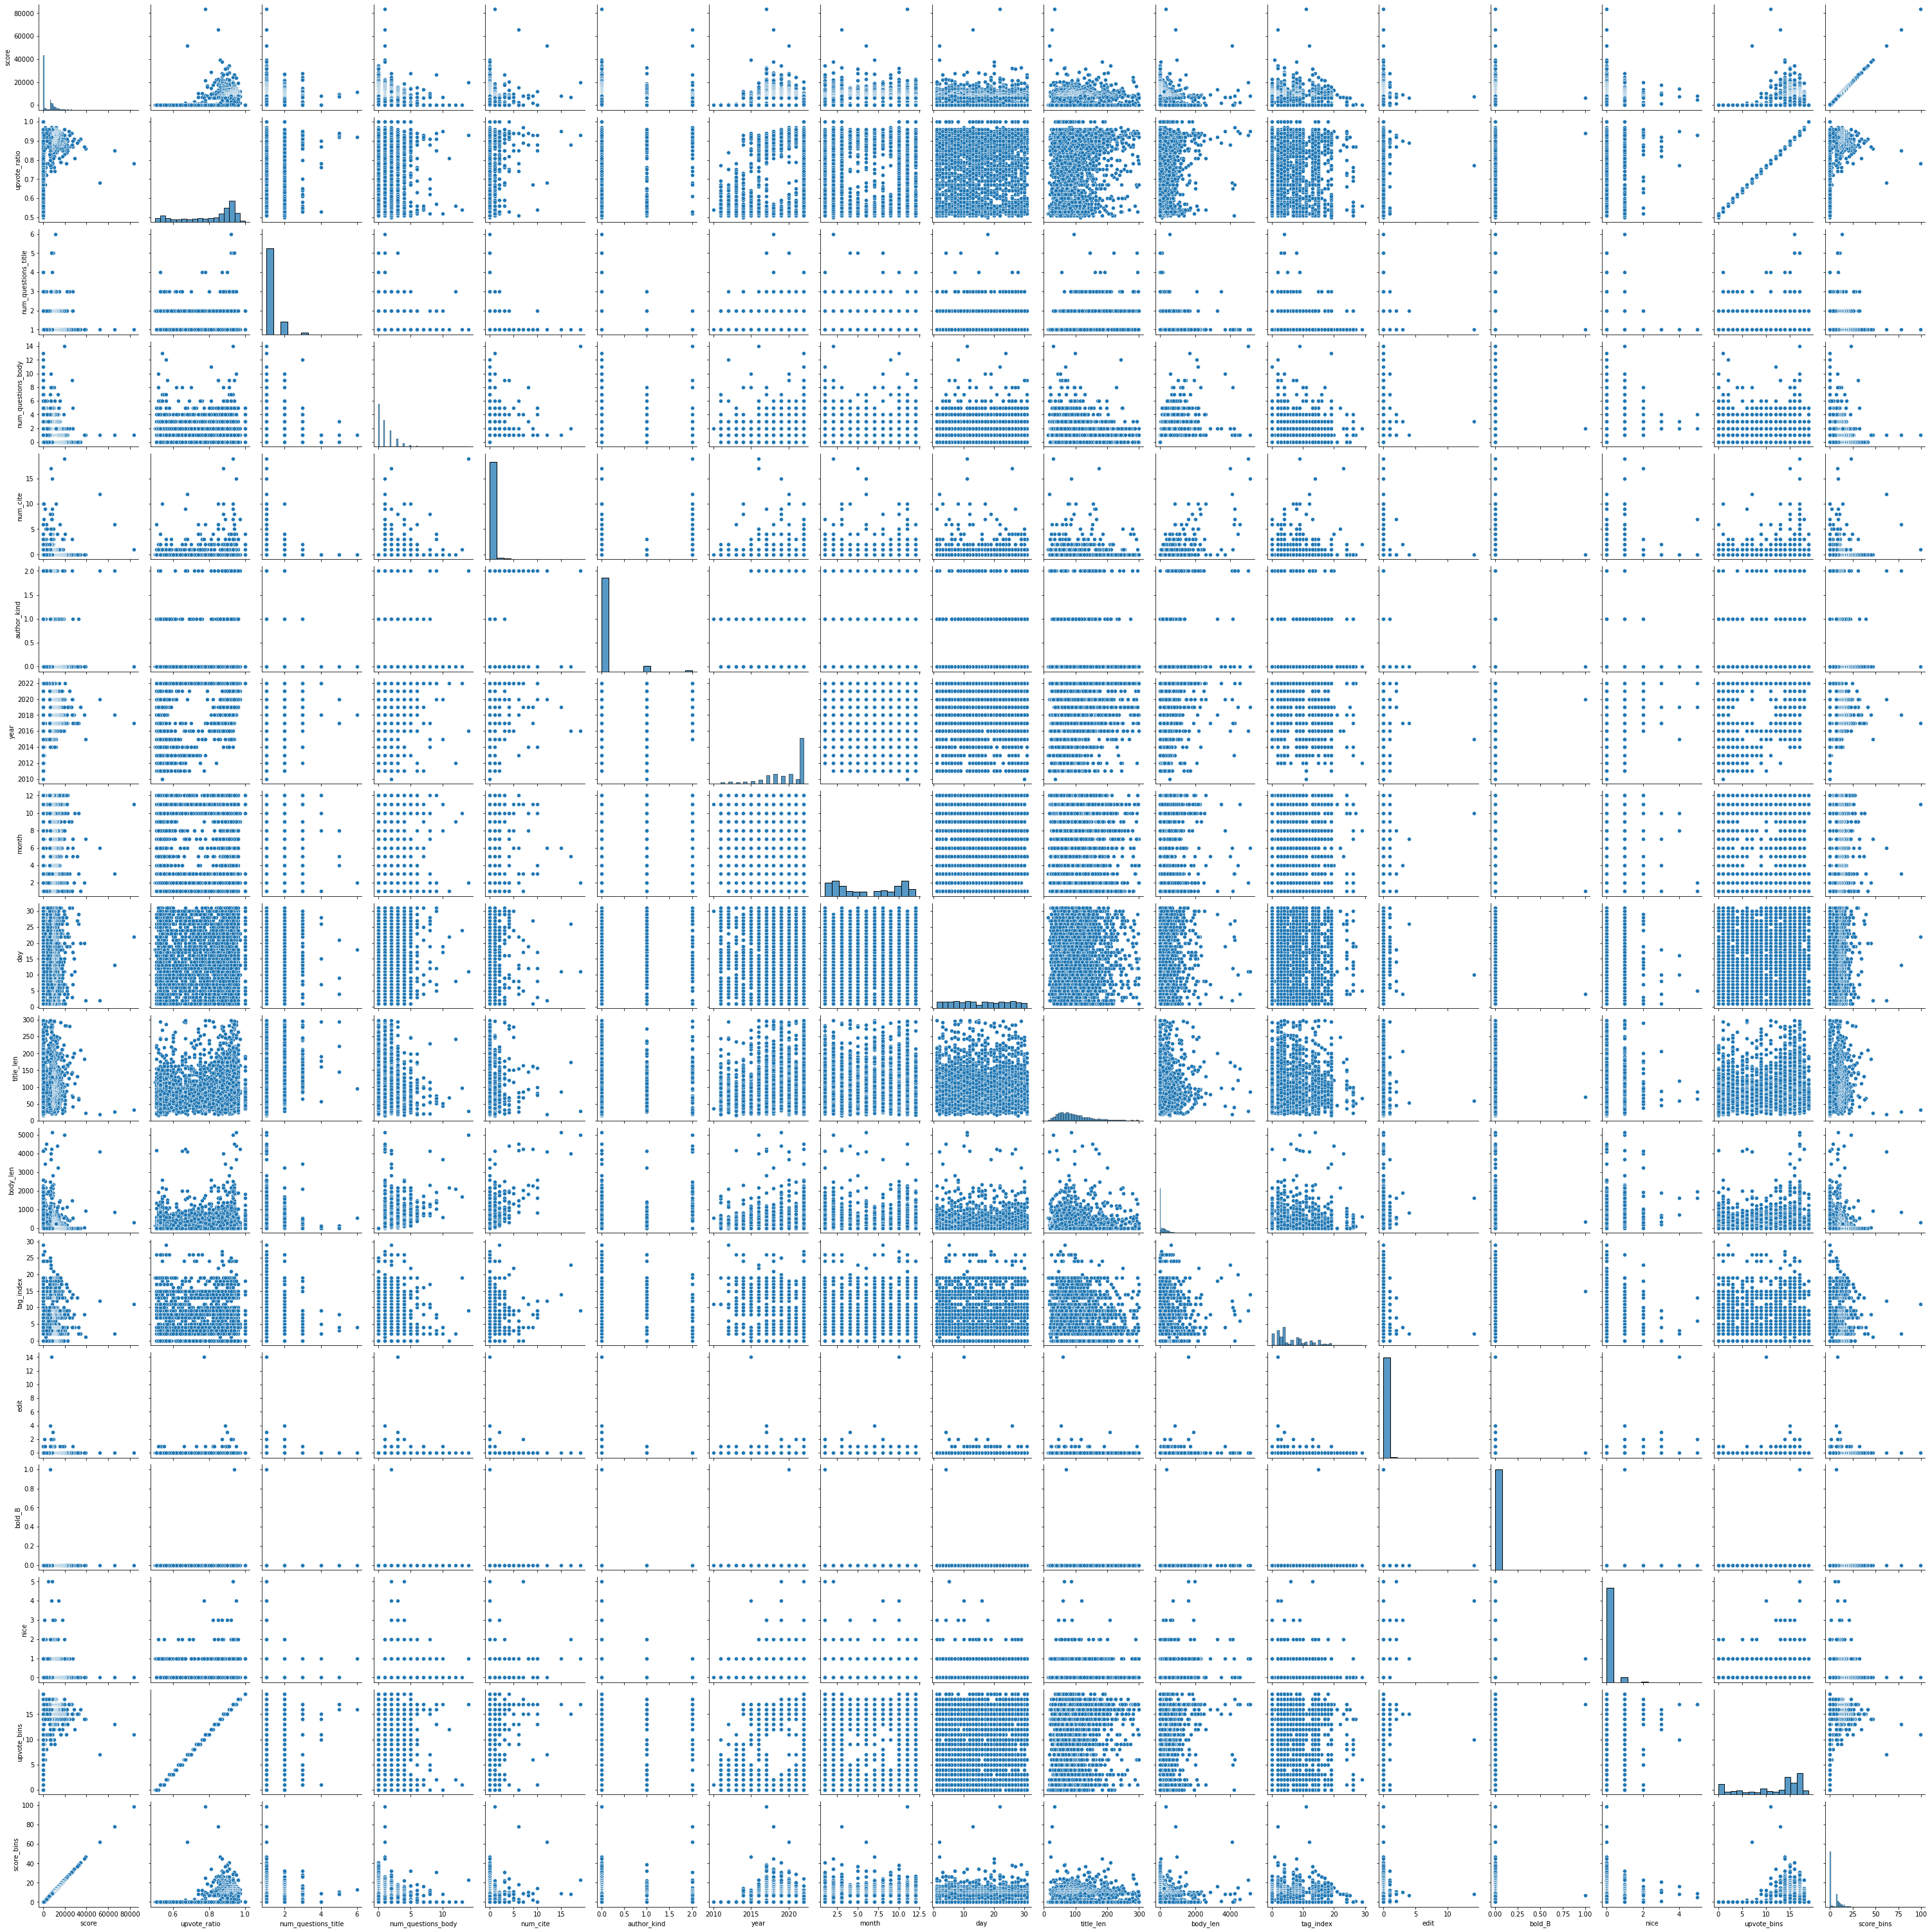

In [20]:
sns.pairplot(df_train_selected)

In [61]:
df_ = pd.read_csv(path_to_data + 'askscience_feat.csv')

In [67]:
# Now let's apply the same process to our df_science dataset. 

df_science_selected = df_[df_['score'] != 0] 
df_science_selected['upvote_bins'] = pd.cut(df_science_selected.upvote_ratio, 20, labels=False) 
df_science_selected['score_bins'] = pd.qcut(df_science_selected.score, 15, labels=False)
df_science_selected['score'] = df_science_selected['score'].apply(lambda x : int(x))


df_science_selected, df_test = train_test_split(df_science_selected, test_size=0.03)

df_test.to_csv(path_to_data + 'askscience_test_data.csv')
print(len(df_test))

111


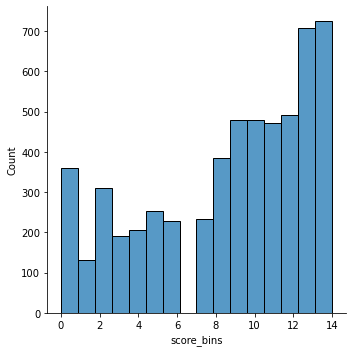

In [68]:
# Oversampling higher score
df_high_score = df_science_selected[df_science_selected['score']>2000]
df_over_sampled = pd.concat((df_science_selected,df_high_score))
df_high_score = df_science_selected[df_science_selected['score']>10000]
df_over_sampled = pd.concat((df_over_sampled,df_high_score))
df_high_score = df_science_selected[df_science_selected['score']>50000]
df_over_sampled = pd.concat((df_over_sampled,df_high_score))
df_high_score = df_science_selected[df_science_selected['score']>60000]
df_over_sampled = pd.concat((df_over_sampled,df_high_score))
df_over_sampled.to_csv(path_to_data + 'askscience_data_processed.csv')

# The distribution of classes is more uniform
sns.displot(df_over_sampled.score_bins)

## Profiling DataFrame

We can also use the pandas profiler to get a summary of everything we've seen so far. You can find the analysis [here](../data/askscience_data_processed_profile.html)

In [66]:
path_to_htmls = '../htmls/'
prof = ProfileReport(df_science_selected)
prof.to_file(output_file=path_to_htmls+'askscience_data_processed_profile.html')

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

# NLP 

We probably exhaused whatever feature we could have extracted from the included metadata. So far, we haven't used any information in the text. 

There are number of ways to take in text into account. For example, we could do further feature engineering to extract features such as sentiment of the text, toxicity, proper grammar, etc. Such knowledge would requier a better understanding of reddit posts however and could be time consumming to find and optimized. Though, I can imagine in practice most companies have a "secret sauce" of what features would best represent their data. 

For this exercise I will use all the text data available in the document.  

In [24]:
from torch.utils.data import DataLoader
from sentence_transformers import InputExample, losses, models, SentenceTransformer
from sklearn import preprocessing
import pickle
from tqdm.contrib.concurrent import process_map
import ast
import torch
import torch.nn as nn
from sklearn.preprocessing import StandardScaler
import sklearn.metrics as metrics
from torchviz import make_dot

2023-08-07 00:00:39.035527: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [25]:
df_science = pd.read_csv(path_to_data + 'askscience_data.csv')
df_science = df_science.drop('Unnamed: 0',axis=1)

In [26]:
def clean_body(text):
    texts = dutil.split_sentence(text)
    return [dutil.replace_chars(text.replace('.','').replace('_','')) for text in texts]

# basic text cleaning. 
dutil = DataUtil()
for col in ['title','body','tag']: 
    df_science[col] = df_science[col].apply(lambda x : dutil.replace_chars(dutil.cleaning_text(x)))
    
df_science = df_science.fillna('')
titles = list(df_science['title'])
bodies = list(df_science['body'])

bodies_processed = [clean_body(body) for body in bodies]
titles_processed = [clean_body(title) for title in titles]

# keeping the order intact (title first, then body) , in case title has something to tell us 
concat_title_body = [x+y if len(y)>1 else x for x,y in zip(titles_processed,bodies_processed)]
df_science['concat_text'] = concat_title_body

idx = 1131
print("concat_text: ",df_science.iloc[idx]['concat_text'])
print("score: ",df_science.iloc[idx]['score'])

df_science.to_csv(path_to_data + 'askscience_data_concat.csv')

concat_text:  ['ask anything wednesday economics political science linguistics anthropology', 'welcome to our weekly feature ask anything wednesday this week we are focusing on economics political science linguistics anthropology do you have a question within these topics you werent sure was worth submitting is something a bit too speculative for a typical raskscience post no question is too big or small for aaw', 'in this thread you can ask any sciencerelated question things like what would happen if', 'how will the future', 'if all the rules for x were different', 'why does my', 'asking questions please post your question as a toplevel response to this and our team of panellists will be here to answer and discuss your questions', 'the other topic areas will appear in future ask anything wednesdays so if you have other questions not covered by this weeks theme please either hold on to it until those topics come around or go and post over in our sister subreddit rasksciencediscussion w

### Fine tuning through predicting the tag given a sentence from title/body 

While we could use an existing pertrained encoder model, most smaller models might not do well by themselves. 

The model used here is [all-MiniLM-L6-v2](https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2), which seen reddit comments from 2015-2018, so it won't know anything about covid-19. 

We know the tag, so we could predict the tag as a downstream task to fine-tune an encoder model if needed. 

and newer topics are about. hence, it will likely benefit from fine-tuning.  We have some labels available. 

This model can handle up to 256 tokens. This is enough for the title, however the body would need to be 
splitted. 

In this notebook I don't discuss if the new fine-tuned embedding model is doign any better/worse than the pre-trained model. Note that it is necessary to ensure that the embeddings are of high quality or else we'll be feeding the model grabage. 


In [37]:
df_science = pd.read_csv(path_to_data + 'askscience_data_concat.csv')

df_science_with_tag = df_science[df_science['tag']!='']
le = preprocessing.LabelEncoder()
tag_labels = le.fit_transform(list(df_science_with_tag['tag']))

pickle.dump(le,open(path_to_data + 'tag_encoder.pickle','wb'))

In [38]:
model = SentenceTransformer('all-MiniLM-L6-v2')
embd_dim = model.get_sentence_embedding_dimension()
len_classes = len(le.classes_)

In [30]:
# Training data
train_examples  = []
for texts,tag in zip(df_science_with_tag['concat_text'],tag_labels):
    texts = ast.literal_eval(texts)
    for i in range(10):
            
        t1 = np.random.choice(texts)
        t2 = np.random.choice(texts)

        train_examples.append(InputExample(texts=[t1,t2],label =tag))

train_dataloader = DataLoader(train_examples, shuffle=True, batch_size=16)


In [31]:
# Training 
epochs = 5
warmup_steps = int(len(train_dataloader) * epochs * 0.1)

train_loss = losses.SoftmaxLoss(model=model, sentence_embedding_dimension=embd_dim, num_labels=len_classes)

model.fit(
    train_objectives=[(train_dataloader, train_loss)],
    epochs=epochs,
    warmup_steps=warmup_steps,
    output_path=path_to_data + 'finetuned_lmmini',
    show_progress_bar=True,
)

# Getting ready for modeling 

let's use the fine-tuned model to extract embeddings from the title and body

We'll use our dataset with zero scores removed and append the concat column to it. 


Extract Embeddings

In [69]:
embed_model = SentenceTransformer(path_to_data + 'finetuned_lmmini')

df_science_p = pd.read_csv(path_to_data + 'askscience_data_processed.csv')
df_science_p = df_science_p.drop([col for col in df_science_p.columns if 'Unn' in col],axis=1)

df_science_t = pd.read_csv(path_to_data + 'askscience_test_data.csv')
df_science_t = df_science_t.drop([col for col in df_science_t.columns if 'Unn' in col],axis=1)
print(len(df_science_p))
print(len(df_science_t))

for col in ['title','body','tag']: 
    df_science_p[col] = df_science_p[col].apply(lambda x : dutil.replace_chars(dutil.cleaning_text(x)))
    df_science_t[col] = df_science_t[col].apply(lambda x : dutil.replace_chars(dutil.cleaning_text(x)))

5652
111


In [70]:
# Train Data
df_science_p = df_science_p.fillna('')
titles       = list(df_science_p['title'])
bodies       = list(df_science_p['body'])

bodies_processed = [clean_body(body)  for body  in bodies]
titles_processed = [clean_body(title) for title in titles]

# keeping the order intact (title first, then body) , 
# in case title has something to tell us 

concat_title_body = [x+y if len(y)>1 else x for x,y in zip(titles_processed,bodies_processed)]
df_science_p['concat_text'] = concat_title_body

embeddings_train = df_science_p['concat_text'].apply(lambda x : embed_model.encode(x))
pickle.dump(embeddings_train,open(path_to_data + 'embeddings_train.pickle','wb'))

In [71]:
# Test Data
df_science_t = df_science_t.fillna('')
titles       = list(df_science_t['title'])
bodies       = list(df_science_t['body'])

bodies_processed = [clean_body(body)  for body  in bodies]
titles_processed = [clean_body(title) for title in titles]

concat_title_body = [x+y if len(y)>1 else x for x,y in zip(titles_processed,bodies_processed)]
df_science_t['concat_text'] = concat_title_body

embeddings_test = df_science_t['concat_text'].apply(lambda x : embed_model.encode(x))
pickle.dump(embeddings_test,open(path_to_data + 'embeddings_test.pickle','wb'))

Since the body is longer than the title, we can perform max pooling to extract document embeddings. 

Seperating title embedding from body embeddings to allow the model learn to learn the importance of thext in title vs. body is important. 

In [72]:
def title_embedding(embeddings):
    title_embedding = embeddings[0]
    return title_embedding

def body_embedding(embeddings):
    if len(embeddings)>1:
        body_embedding = np.max(embeddings[1:],0)
    else: 
        body_embedding = embedding_empty
    return body_embedding

# using this embedding when body is empty to make modeling easier later. 
embedding_empty = embed_model.encode('empty')

In [73]:
df_science_p['embeddings'] = embeddings_train
title_embedding_train = df_science_p['embeddings'].apply(lambda x : title_embedding(x))
body_embedding_train  = df_science_p['embeddings'].apply(lambda x : body_embedding(x))
pickle.dump(list(title_embedding_train),open(path_to_data + 'title_embeddings_train.pickle','wb'))
pickle.dump(list(body_embedding_train) ,open(path_to_data + 'body_embeddings_train.pickle','wb'))

In [74]:
df_science_t['embeddings'] = embeddings_test
title_embedding_test = df_science_t['embeddings'].apply(lambda x : title_embedding(x))
body_embedding_test  = df_science_t['embeddings'].apply(lambda x : body_embedding(x))
pickle.dump(list(title_embedding_test),open(path_to_data + 'title_embeddings_test.pickle','wb'))
pickle.dump(list(body_embedding_test) ,open(path_to_data + 'body_embeddings_test.pickle','wb'))

In [75]:
df_science_p.to_csv(path_to_data + 'ask_science_ml_train.csv')
df_science_t.to_csv(path_to_data + 'ask_science_ml_test.csv')

# Let's model ! 

We're going to create a model that classifies a post into one of the 20 perdefined score buckets. 
The input to the model is the title embedding, body embedding, and the additional features (metadata) that we discussed in the beginning of the notebook. 

The model passes the title embedding, body embedding and the feature vector through three seperate networks, concatenates the output and then backporpagaes the gradients through the concatenated output. 

## Collecting title and body embeddings 

In [76]:
# Train 
title_embeddings_train = pickle.load(open(path_to_data + 'title_embeddings_train.pickle','rb'))
body_embeddings_train  = pickle.load(open(path_to_data + 'body_embeddings_train.pickle','rb'))

# Concatenating title and body embeddings and saving it to use later 
title_embeddings_train  = np.array(title_embeddings_train)
body_embeddings_train   = np.array(body_embeddings_train)
concat_embeddings = []

for x,y in zip(title_embeddings_train,body_embeddings_train):
    concat_embeddings.append(np.array([x,y]).T)
    
concat_embeddings = np.array(concat_embeddings)
pickle.dump(concat_embeddings,open(path_to_data + 'concat_embeddings_train.pickle','wb'))

In [77]:
# Test 
title_embeddings_test = pickle.load(open(path_to_data + 'title_embeddings_test.pickle','rb'))
body_embeddings_test  = pickle.load(open(path_to_data + 'body_embeddings_test.pickle','rb'))

# Concatenating title and body embeddings and saving it to use later 
title_embeddings_test  = np.array(title_embeddings_test)
body_embeddings_test   = np.array(body_embeddings_test)
concat_embeddings = []

for x,y in zip(title_embeddings_test,body_embeddings_test):
    concat_embeddings.append(np.array([x,y]).T)
    
concat_embeddings = np.array(concat_embeddings)
pickle.dump(concat_embeddings,open(path_to_data + 'concat_embeddings_test.pickle','wb'))

## Additional feature metadata

As a reminder I explicitly recall all the feature vectors we have collected so far. We'll use them in conjunction with the embeddings to train a model that learns to classify a reddit post on askscience into one 20 score buckers

In [79]:
# Train

df_train = pd.read_csv(path_to_data + 'ask_science_ml_train.csv')
df_train = df_train.drop('Unnamed: 0',axis=1)

num_qs_title = list(df_train['num_questions_title'])
num_qs_body  = list(df_train['num_questions_body'])
num_cite     = list(df_train['num_cite'])
author_kind  = list(df_train['author_kind'])
year         = np.array(list(df_train['year']))
month        = list(df_train['month'])
day          = list(df_train['day'])
tlen         = np.array(list(df_train['title_len']))
blen         = np.array(list(df_train['body_len']))
tind         = list(df_train['tag_index'])
edit         = list(df_train['edit'])
bold         = list(df_train['bold_B'])
nice         = list(df_train['nice'])

# author_kind,year,
feature_vector_meta_train = [num_qs_title,num_qs_body,num_cite,blen,tlen,tind,month,day,author_kind,year,edit,bold,nice]
feature_vector_meta_train = np.array(feature_vector_meta_train).T

len_Feat = len(feature_vector_meta_train.T)
print("Len Feature Vector", len_Feat)
pickle.dump(feature_vector_meta_train,open(path_to_data + 'feature_vector_meta_train.pickle','wb'))


Len Feature Vector 13


In [80]:
# Test
df_test = pd.read_csv(path_to_data + 'ask_science_ml_test.csv')
df_test = df_test.drop('Unnamed: 0',axis=1)

num_qs_title = list(df_test['num_questions_title'])
num_qs_body  = list(df_test['num_questions_body'])
num_cite     = list(df_test['num_cite'])
author_kind  = list(df_test['author_kind'])
year         = np.array(list(df_test['year']))
month        = list(df_test['month'])
day          = list(df_test['day'])
tlen         = np.array(list(df_test['title_len']))
blen         = np.array(list(df_test['body_len']))
tind         = list(df_test['tag_index'])
edit         = list(df_test['edit'])
bold         = list(df_test['bold_B'])
nice         = list(df_test['nice'])

# author_kind,year,
feature_vector_meta_test = [num_qs_title,num_qs_body,num_cite,blen,tlen,tind,month,day,author_kind,year,edit,bold,nice]
feature_vector_meta_test = np.array(feature_vector_meta_test).T

len_Feat = len(feature_vector_meta_test.T)
pickle.dump(feature_vector_meta_test,open(path_to_data + 'feature_vector_meta_test.pickle','wb'))


###  Labels
We'll start with using the score_bins as the labels the model will learn from. 

In [81]:
upvote_bins   = np.array(df_train['upvote_bins'])
score_bins    = np.array(df_train['score_bins'])

score         = np.array(df_train['score'])
upvote_ratio  = np.array(df_train['upvote_ratio'])

label_mapping = {k:idx for idx, k in enumerate(set(score_bins))} # mapping labels to indicies

train_labels        = np.array([label_mapping[k] for k in score_bins])

num_labels = len(set(train_labels))
len_labels = len(Counter(train_labels))

Counter(train_labels)

Counter({6: 227,
         3: 191,
         0: 361,
         2: 309,
         7: 234,
         9: 480,
         1: 132,
         14: 725,
         13: 708,
         5: 252,
         12: 492,
         8: 384,
         4: 205,
         10: 480,
         11: 472})

In [82]:
score_bins_test = np.array(df_test['score_bins'])
test_labels     = np.array([label_mapping[k] for k in score_bins_test])
Counter(test_labels)

Counter({9: 7,
         3: 9,
         6: 6,
         14: 7,
         0: 11,
         13: 9,
         12: 8,
         4: 9,
         11: 9,
         10: 7,
         2: 7,
         7: 10,
         1: 4,
         5: 5,
         8: 3})

## Split Data and Normalizing 

I only normalize the feature vector since the values in this feature vector are at very different scales. 

Since we oversampled the data, we need to be a little more careful on how we're going to split our dataset. 

We previously, set 3% of the original data out for testing and oversampled the remaining 97%. 

Due to limited computational power and time, I decicded to skip the cross/validation set. Note that in practice, validation set should be used to fine-tune the model hyperparameters. 

The feature vector of the test data is also normalized using the normalization that was learned from the training data. 

In [83]:
# Training data 
train_embeddings          = pickle.load(open(path_to_data + 'concat_embeddings_train.pickle','rb'))
feature_vector_train      = pickle.load(open(path_to_data + 'feature_vector_meta_train.pickle','rb'))

scaler      = StandardScaler()
train_feat  = feature_vector_train
scalar_feat = scaler.fit(train_feat)
pickle.dump(scalar_feat,open(path_to_data + 'scalar_feat.pickle','wb')) # normalization for feature vector

train_feat  = scalar_feat.transform(train_feat)


In [84]:
# Training data 
test_embeddings          = pickle.load(open(path_to_data + 'concat_embeddings_test.pickle','rb'))
feature_vector_test      = pickle.load(open(path_to_data + 'feature_vector_meta_test.pickle','rb'))

test_feat  = scalar_feat.transform(feature_vector_test)


In [85]:
print("Num Training data ", len(train_feat))
print("Num Testing data " , len(test_feat))

Num Training data  5652
Num Testing data  111


## Creating a data loader object for our model 


In [86]:
from torch.utils.data import DataLoader, Dataset

class MyDataset(Dataset):
    def __init__(self, data, target):
        self.data   = torch.from_numpy(data[0]).float()
        self.feat   = torch.from_numpy(data[1]).float()
        self.target = torch.from_numpy(target).long()
        
    def __getitem__(self, index):
        x = self.data[index]
        f = self.feat[index]
        y = self.target[index]
        return x,f, y
    
    def __len__(self):
        return len(self.data)
    


### Model Architecture

In [87]:
class RedditNet(nn.Module):
    def __init__(self):
        super(RedditNet, self).__init__()
        
        self.drop_out = nn.Dropout(0.35)
        self.relu = nn.ReLU()
    
        # embeddings
        self.fc1 = nn.Linear(384, 512)
        self.bn0 = nn.BatchNorm1d(512)
        self.fc2 = nn.Linear(512, 256)
        self.bn1 = nn.BatchNorm1d(256)
        self.fc3 = nn.Linear(256, 128)
        self.bn2 = nn.BatchNorm1d(128)
        
        # feature 
        self.fc4 = nn.Linear((len_Feat), 128)
        self.bn3 = nn.BatchNorm1d(128)
        self.fc5 = nn.Linear(128 , 256)
        
        #concat layer
        self.bn4 = nn.BatchNorm1d(512)
        self.fc6 = nn.Linear(512,512)
        self.fc7 = nn.Linear(512,64)
        self.fc8 = nn.Linear(64, num_labels)
        
    def forward(self, x1,x2):

        out1  = self.bn0(self.relu(self.fc1(x1[:,:,0]))) # title embedding
        out1  = self.drop_out(out1)
        out11 = self.bn1(self.relu(self.fc2(out1))) # title embedding
        out11 = self.drop_out(out11)
        out12 = self.bn2(self.relu(self.fc3(out11))) # title embedding
        
        out2  = self.bn0(self.relu(self.fc1(x1[:,:,1]))) #body embedding
        out2  = self.drop_out(out2)
        out21 = self.bn1(self.relu(self.fc2(out2))) # body embedding
        out21 = self.drop_out(out21)
        out22 = self.bn2(self.relu(self.fc3(out21))) # body embedding
        
        out4  = self.bn3(self.relu(self.fc4(x2))) #feature vector
        out5  = self.fc5(out4)

        out6  = self.bn4(torch.cat((out12,out22,out5),axis=-1)) # concatenating the outputs
        out6  = self.drop_out(out6)
        out7  = self.fc6(out6)
        out8  = self.fc7(out7)
        out   = self.fc8(out8)
        
        return out

# Train the model


In [88]:
# Instantiating data objects
batch_size   = 32
train_data   = MyDataset([train_embeddings,train_feat], train_labels)
train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)

test_data    = MyDataset([test_embeddings,test_feat], test_labels)
test_loader  = DataLoader(dataset=test_data, batch_size=1, shuffle=True)

In [89]:
# Instantiating model 
model = RedditNet()

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


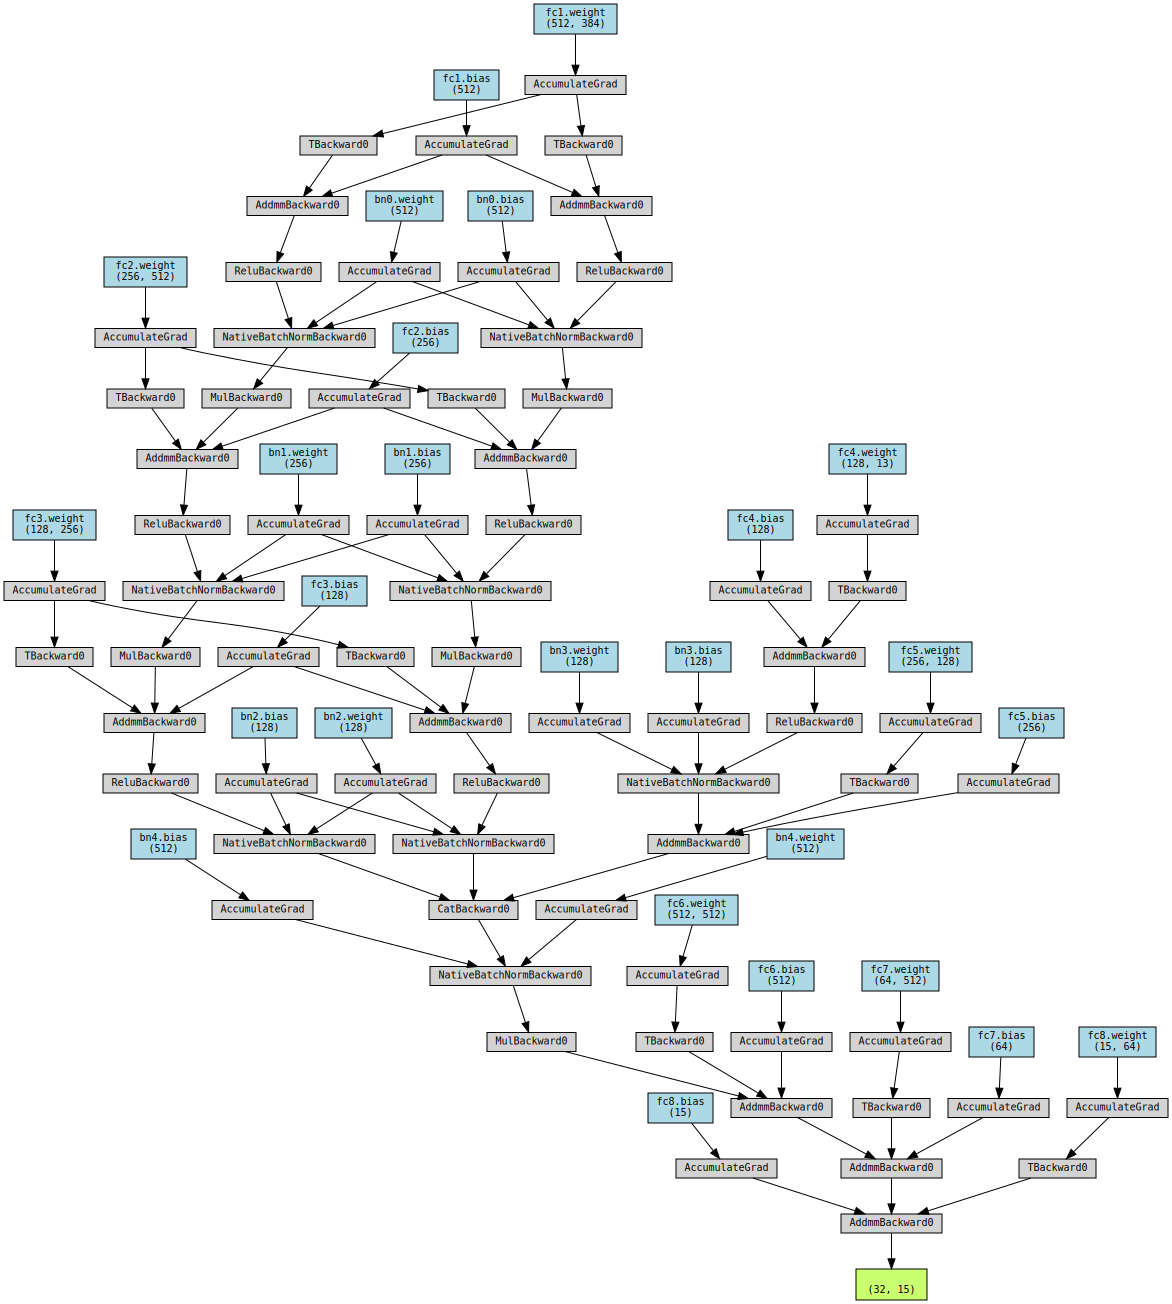

In [90]:
# let's take a look at the model architecture
for i, (data_t,feat, labels) in enumerate(train_loader):
    outputs = model(data_t,feat)
    break
make_dot(outputs, params=dict(list(model.named_parameters())))

In [ ]:
# Instantiating data objects
model = RedditNet()
batch_size   = 16
train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)

# Model Fit
learning_rate = 0.0005
criterion  = nn.CrossEntropyLoss() # cross entropy loss for classification
optimizer  = torch.optim.Adam(model.parameters(), lr=learning_rate)

total_step = len(train_loader)/batch_size
num_epochs = 501
loss_list  = []
acc_list   = []

for epoch in range(num_epochs):
    loss_list_element = 0
    acc_list_element  = 0
    for i, (data_t,feat, labels) in enumerate(train_loader):
        # forward
        outputs = model(data_t,feat)
        loss    = criterion(outputs, labels)
        loss_list_element += loss.item()
            
        # Backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        _, predicted = torch.max(outputs.data, 1)
        correct = (predicted == labels).sum().item()
        acc_list_element += correct
    
    loss_list_element = loss_list_element/(i*batch_size)
    acc_list_element  = acc_list_element/(i*batch_size)
    if epoch % 20 == 0:
        print('Epoch [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'
              .format(epoch + 1, num_epochs, loss_list_element,acc_list_element * 100))  
    loss_list.append(loss_list_element)
    acc_list.append(acc_list_element)
    

Epoch [1/501], Loss: 0.1512, Accuracy: 18.45%
Epoch [21/501], Loss: 0.1142, Accuracy: 37.02%
Epoch [41/501], Loss: 0.1035, Accuracy: 43.82%
Epoch [61/501], Loss: 0.0979, Accuracy: 46.92%
Epoch [81/501], Loss: 0.0948, Accuracy: 48.96%
Epoch [101/501], Loss: 0.0911, Accuracy: 50.27%
Epoch [121/501], Loss: 0.0890, Accuracy: 51.82%
Epoch [141/501], Loss: 0.0882, Accuracy: 52.11%
Epoch [161/501], Loss: 0.0868, Accuracy: 53.45%
Epoch [181/501], Loss: 0.0851, Accuracy: 54.04%


In [ ]:
torch.save(model, path_to_data  + 'classification_model')

# Evaluating 

This is the remaining 3% of the data we left out for testing, about 110 samples. Please note that in practice this isn't nearly enough data predict the performance of a model. 

In [ ]:
prs = []
ls  = []
model.eval()
with torch.no_grad():
    correct = 0
    for idx, (data_t,feat, labels) in enumerate(test_loader):
        outputs       = model(data_t,feat)
        _, predicted  = torch.max(outputs.data, 1)
        correct      += (predicted == labels).sum().item()
        prs.append(predicted.numpy()[0])
        ls.append(labels.numpy()[0])

    print('Test Accuracy of the model: {} %'.format((correct /idx) * 100))


The accuracy of the classification model leaves much room for improvements. 

It is quiet possible that the model needs to be further fine-tuned and some other archtiecture or features may be needed to improve the model accuracy. Also, training a deep learning model to do such classification might be requier much more training data to ensure the model isn't overfitting to the training set and generalizing its parameters to unseen data.  

A careful look at the bins reveals that the model is doing better than it seems by looking at the RMSE. 

In [ ]:
plt.figure(figsize=(15,6))
plt.plot(prs,'x')
plt.plot(ls)
plt.ylabel('Samples')
plt.ylabel('Score Bins')
plt.legend(['prediction','ground truth'])

In [ ]:
# rmse error
metrics.mean_squared_error(ls,prs,squared=False)